# 市場構造変化の把握 (ChatGPT)

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# df = yf.download('AAPL', start='2023-01-01', end='2024-01-01', interval='1d', multi_level_index=False)

🔍 BOS（構造のブレイク）と CHoCH（キャラクターの変化）とは？
BOS（Break of Structure）
　現在のトレンド（上昇 or 下降）の方向に価格が以前の高値または安値を更新（突破）すること。
　👉 これはトレンド継続のサインとされます。

CHoCH（Change of Character）
　現在のトレンドとは逆方向に価格がブレイクした場合。
　👉 これはトレンドの反転の可能性を示す重要なサインです。

🔧 全体の流れ（Python実装）
① スイング高値・安値を検出する
一定期間内で一番高い「スイングハイ」と、一番低い「スイングロー」を見つけます。

In [3]:
def detect_swings(df, lookback=3):
    df['swing_high'] = df['High'][
        (df['High'].shift(lookback) < df['High']) &
        (df['High'].shift(-lookback) < df['High'])
    ]
    df['swing_low'] = df['Low'][
        (df['Low'].shift(lookback) > df['Low']) &
        (df['Low'].shift(-lookback) > df['Low'])
    ]
    return df

② BOS・CHoCHを判定する
以下のようなロジックで進めます：

前回のスイング高値・安値と比較

トレンドが上昇中に安値を下回ったら「CHoCH」

トレンドが下降中に高値を上回ったら「CHoCH」

同じ方向なら「BOS」

In [4]:
def find_bos_choch(df):
    structure = []
    trend = 'initial'
    last_high = -float('inf')
    last_low = float('inf')

    for i in range(len(df)):
        row = df.iloc[i]

        if not np.isnan(row['swing_high']):
            if (trend == 'down' or trend == 'initial') and row['High'] > last_high:
                structure.append('CHoCH')  # 下降トレンド → 高値を超える → 転換
                trend = 'up'
            elif (trend == 'up' or trend == 'initial') and row['High'] > last_high:
                structure.append('BOS')    # 上昇トレンド継続
            else:
                structure.append(None)
            last_high = row['High']
        
        elif not np.isnan(row['swing_low']):
            if (trend == 'up' or trend == 'initial') and row['Low'] < last_low:
                structure.append('CHoCH')  # 上昇トレンド → 安値を割る → 転換
                trend = 'down'
            elif (trend == 'down' or trend == 'initial') and row['Low'] < last_low:
                structure.append('BOS')    # 下降トレンド継続
            else:
                structure.append(None)
            last_low = row['Low']

        else:
            structure.append(None)
    df['structure'] = structure
    return df

✅ 実際に使ってみる

In [5]:
# 評価する銘柄
ticker = '4755.T'
# 期間の指定
end_date = datetime.today()
start_date = end_date - timedelta(days=730)

# 株価データ取得
df = yf.download(ticker, start=start_date, end=end_date, interval='1d', multi_level_index=False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
# スイングポイント → BOS/CHoCH検出
df = detect_swings(df,lookback=5)
df = find_bos_choch(df)

# 結果の表示（BOSとCHoCHのみ）
print(df[df['structure'].notna()][['High', 'Low', 'structure']])

                  High         Low structure
Date                                        
2023-07-11  545.700012  531.900024     CHoCH
2023-07-13  547.500000  536.500000       BOS
2023-07-14  566.599976  549.099976       BOS
2023-07-19  540.700012  522.799988     CHoCH
2023-07-28  551.900024  527.099976       BOS
...                ...         ...       ...
2025-05-30  800.200012  791.500000       BOS
2025-06-02  822.799988  787.099976       BOS
2025-06-03  824.000000  806.200012     CHoCH
2025-06-09  824.500000  805.799988       BOS
2025-06-11  836.000000  819.099976       BOS

[115 rows x 3 columns]


📈 オプション：チャートで可視化

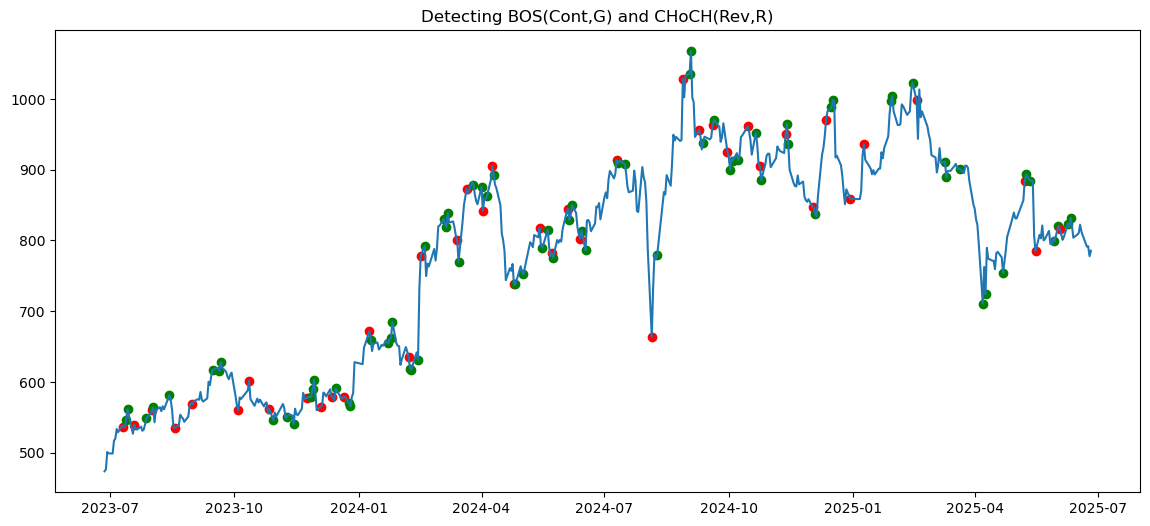

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')

# BOS/CHoCHにマーカーを表示
for idx, row in df[df['structure'].notna()].iterrows():
    color = 'green' if row['structure'] == 'BOS' else 'red'
    plt.scatter(idx, df.loc[idx, 'Close'], color=color, label=row['structure'])

plt.title('Detecting BOS(Cont,G) and CHoCH(Rev,R)')
plt.show()

💡 補足ポイント
lookback=3 は、スイングの鋭さを調整するパラメータです。値を小さくするとより頻繁にスイングを検出します。

ボラティリティが高い相場では、偽のCHoCHが発生しやすいため注意。

トレンドフィルター（移動平均やADXなど）と組み合わせると、さらに精度が上がります。